# Model Based Recursive Partitioning 
https://cran.r-project.org/web/packages/party/vignettes/MOB.pdf

In [2]:
# install.packages("party")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TH.data’, ‘matrixStats’, ‘multcomp’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘sandwich’




In [3]:
library("party")

data("BostonHousing", package = "mlbench")

Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich



In [17]:

options(repr.plot.width = 20, repr.plot.height = 10)

n = 506 observations of the median value of owner-occupied homes in Boston (in USD 1000) along with 14 covariates including 
in particular the number of rooms per dwelling (rm) and the percentage of lower status of the population (lstat). 

A segment-wise linear relationship between the value and these two variables is very intuitive, whereas the shape of the influence of the remaining 
covariates is rather unclear and hence should be learned
from the data. 

In [5]:
BostonHousing$lstat <- log(BostonHousing$lstat)
BostonHousing$rm <- BostonHousing$rm^2

Choosing appropriate transformations of the dependent variable and the regressors that enter
the linear regression model is important to obtain a well-fitting model in each segment and
we follow in our choice the recommendations of Breiman and Friedman (1985). 

Monotonous transformations of the partitioning variables do not affect the recursive partitioning algorithm
and hence do not have to be performed. However, it is important to distinguish between
numerical and categorical variables for choosing an appropriate parameter stability test. 

The
variable chas is a dummy indicator variable (for tract bounds with Charles river) and should
thus be turned into a factor. Furthermore, the variable rad is an index of accessibility to
radial highways and takes only 9 distinct values. Thus it is most appropriately treated as an
ordered factor.

In [6]:
BostonHousing$chas <- factor(BostonHousing$chas, levels = 0:1, labels = c("no", "yes"))
BostonHousing$rad <- factor(BostonHousing$rad, ordered = TRUE)

Both transformations only affect the parameter stability test chosen (step 2), not the splitting
procedure (step 3).
The model is estimated by OLS, the instability is assessed using a Bonferroni-corrected significance level of α = 0.05 and the nodes are split with a required minimal segment size of 40
observations. The control parameters are thus set to

In [7]:
ctrl <- mob_control(alpha = 0.05, bonferroni = TRUE, minsplit = 40, objfun = deviance, verbose = TRUE)

Actually, all of these settings are the defaults except minsplit = 40 and verbose = TRUE
which causes some information about the fitting process being written to the screen. The
objective function deviance() extracts in this case the residual sum of squares from a fitted
linearModel object.
Having collected all building blocks, we can now call the function mob() that takes the model
specification of the linear regression model medv ~ lstat + rm plus all partitioning variables,
along with the data set, the control settings and the model to be used.

In [8]:
fmBH <- mob(medv ~ lstat + rm | zn + indus + chas + nox + age + dis + rad + tax + crim + b + ptratio,
            control = mob_control(minsplit = 40), data = BostonHousing, model = linearModel)

The result is the fitted model fmBH of class “mob” that contains the tree with a fitted linear
regression associated with every node. Printing this object will show the splits, their p values
and call the print() method for the model in each terminal node (i.e., this simply relies on
a print() method being available for the fitted model and re-uses it)

In [9]:
fmBH

1) tax <= 432; criterion = 1, statistic = 115.364
  2) ptratio <= 15.2; criterion = 1, statistic = 50.482
    3)*  weights = 72 
Terminal node model
Linear model with coefficients:
(Intercept)        lstat           rm  
     9.2349      -4.9391       0.6859  

  2) ptratio > 15.2
    4) ptratio <= 19.6; criterion = 1, statistic = 55.266
      5) tax <= 265; criterion = 1, statistic = 43.178
        6)*  weights = 63 
Terminal node model
Linear model with coefficients:
(Intercept)        lstat           rm  
     3.9637      -2.7663       0.6881  

      5) tax > 265
        7)*  weights = 162 
Terminal node model
Linear model with coefficients:
(Intercept)        lstat           rm  
    -1.7984      -0.2677       0.6539  

    4) ptratio > 19.6
      8)*  weights = 56 
Terminal node model
Linear model with coefficients:
(Intercept)        lstat           rm  
    17.5865      -4.6190       0.3387  

1) tax > 432
  9)*  weights = 153 
Terminal node model
Linear model with coefficients

Looking at the printed output is typically rather tedious, a visualization via the plot()
method

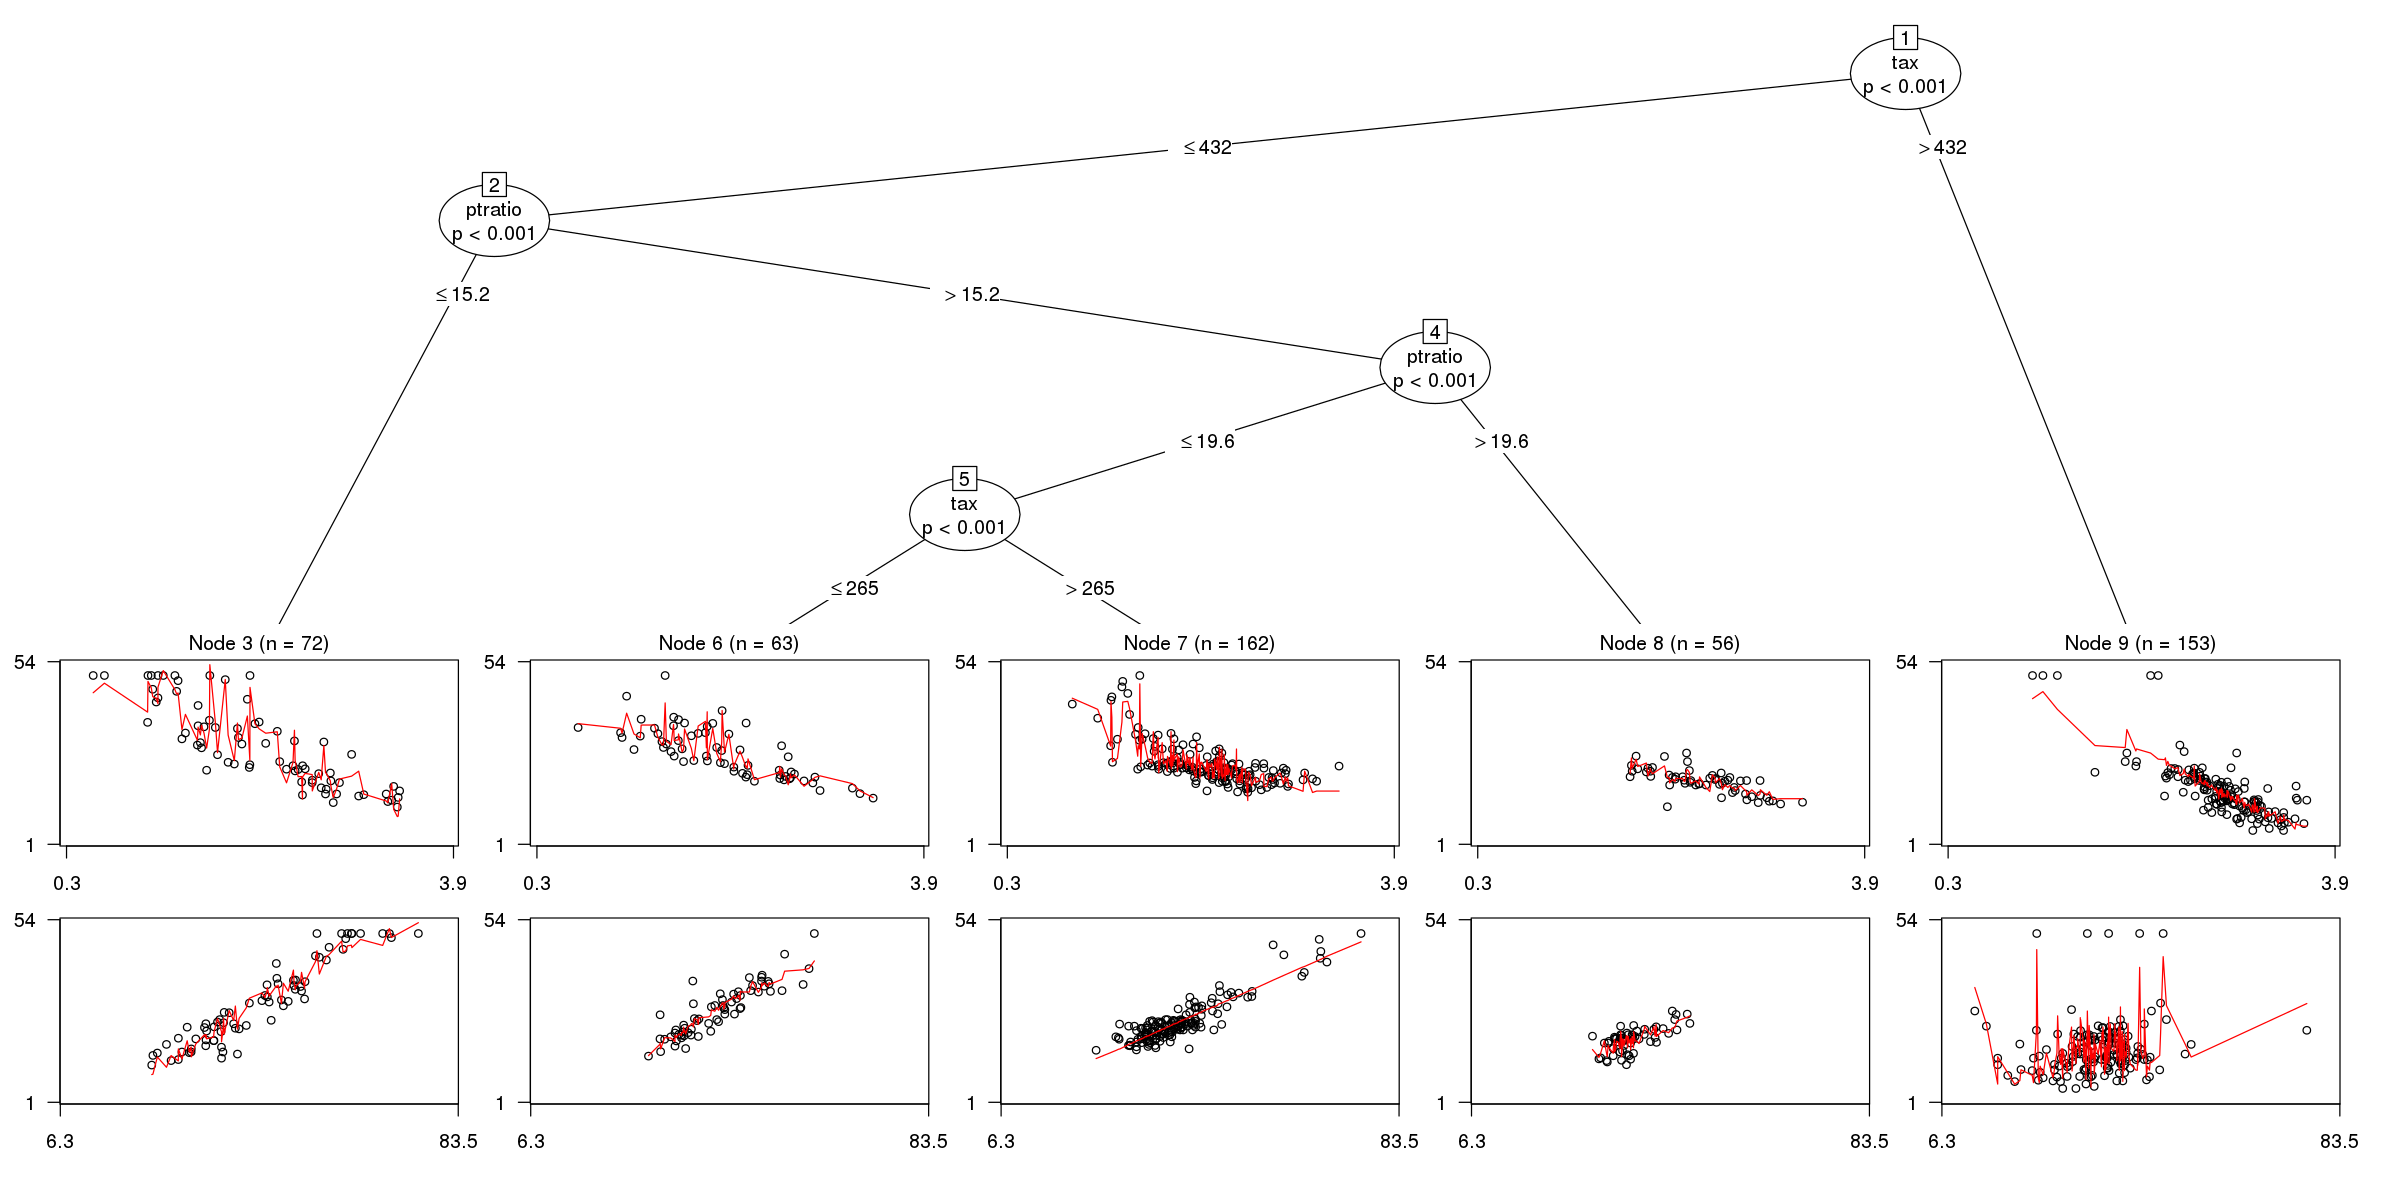

In [18]:
plot(fmBH)

is much easier to interpret. By default, this produces partial scatter plots of the variable y
against each of the regressors xi
in the terminal nodes. Each scatter plot also shows the fitted
values, i.e., a project of the fitted hyperplane.
From this visualization, it can be seen that in the nodes 4, 6, 7 and 8 the increase of value with
the number of rooms dominates the picture (upper panel) whereas in node 9 the decrease with
the lower status population percentage (lower panel) is more pronounced. Splits are performed
in the variables tax (poperty-tax rate) and ptratio (pupil-teacher ratio).
Various quantities of interest can be computed, provided that the model used provides the
corresponding methods, e.g., predict(), residuals(), logLik(), coef() and summary().
The latter two by default try to extract information for the terminal nodes, but a node
argument can be set to the node IDs of interest. As an example, the regression coefficients
for the terminal node models can be easily extracted by

In [19]:
coef(fmBH)

,(Intercept),lstat,rm
3,9.234880,-4.939096,0.6859136
6,3.963720,-2.766287,0.6881287
7,-1.798387,-0.267707,0.6538864
8,17.586490,-4.618975,0.3386744
9,68.297087,-16.354006,-0.1477939


reflecting the differences of the models that can also be seen in the the associated plot().
Even more information is available in a summary(), e.g., for node 7:

In [20]:
summary(fmBH, node = 7)


Call:
NULL

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-9.092  0.000  0.000  0.000 10.236 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.79839    2.84702  -0.632    0.529    
lstat       -0.26771    0.69581  -0.385    0.701    
rm           0.65389    0.03757  17.404   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.652 on 159 degrees of freedom
Multiple R-squared:  0.8173,	Adjusted R-squared:  0.815 
F-statistic: 355.6 on 2 and 159 DF,  p-value: < 2.2e-16


The test statistics and p values computed in each node, can be extracted analogously by using
the method for the function sctest() (for performing structural change tests).

In [25]:
sctest(fmBH, node = 7)

,zn,indus,chas,nox,age,dis,rad,tax,crim,b,ptratio
statistic,11.998039,7.3971233,7.227770,9.2936189,14.3023962,8.9239826,33.1746444,16.6666129,11.7143758,9.9050903,11.5927528
p.value,0.574642,0.9931875,0.522447,0.9119621,0.2886603,0.9389895,0.3926249,0.1206412,0.6153455,0.8539893,0.6328381


For summarizing the quality of the fit, we could compute the mean squared error, loglikelihood or AIC:

In [23]:
mean(residuals(fmBH)^2)

[1] 12.03518

In [22]:
logLik(fmBH)

'log Lik.' -1310.506 (df=24)

In [21]:
AIC(fmBH)

[1] 2669.013

As the logLik() method simply re-uses the method for linearModel objects, this does not
only report 19 estimated parameters (3 parameters in each of the 5 terminal nodes plus 5 − 1
Achim Zeileis, Torsten Hothorn, Kurt Hornik 11
split points) but 24 parameters because each terminal node is additionally associated with a
variance estimate. However, for the fitting process, the variance was treated as a nuisance
parameter as we employed OLS estimation (rather than fully-specified ML estimation).

# Try it on expiry data

In [26]:
source('functions_eval.R')

source('load_prep_data_expiry.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [27]:
set.seed(123)
# tr_idxs <- sample(seq_len(nrow(expiry_train_df_sub)), size = floor(0.05 * nrow(expiry_train_df_sub)))
# ts_idxs <- sample(seq_len(nrow(expiry_test_df_sub)), size = floor(0.05 * nrow(expiry_test_df_sub)))

# tr <- expiry_train_df_sub[tr_idxs, ] 
# ts <- expiry_test_df_sub[ts_idxs, ] 

tr <- 


dim(tr)
dim(ts)

[1] 59412    12

[1] 14839    12

In [28]:
str(tr)

Classes ‘data.table’ and 'data.frame':	59412 obs. of  12 variables:
 $ renewal_status      : Factor w/ 2 levels "Not Renewd","Renewed": 1 1 1 1 1 1 1 1 1 1 ...
 $ tld                 : Factor w/ 11 levels "fun","host","in.net",..: 1 11 7 6 4 7 7 7 8 7 ...
 $ registrar           : chr  "reg.ru" "uniregistrar" "gmo" "namecheap" ...
 $ reseller_country    : chr  "Russia" "Cayman Islands" "Japan" "United States" ...
 $ region              : chr  "Non China" "Non China" "Non China" "Non China" ...
 $ reg_period          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sld_type            : Factor w/ 6 levels "hyphen-l","l",..: 3 2 2 2 2 2 1 2 3 4 ...
 $ sld_length          : int  9 10 6 9 8 9 20 6 10 21 ...
 $ day_domains         : int  78 77 3965 571 1269 16 166 2377 10 5675 ...
 $ gibb_score          : num  4.71 3.88 0.14 1.42 7.63 2.62 8.69 0.12 9.83 5.08 ...
 $ pattern_domain_count: int  1 1 2 2 3 1 3 2 1 204 ...
 $ reg_arpt            : num  0.5 1 0.1 1.09 0.75 0.4 0.5 0.1 0.3 0.5 ...
 - attr(*, ".in

In [30]:
tr <- tr %>%
  mutate_if(sapply(tr, is.character), as.factor)
ts <- ts %>%
  mutate_if(sapply(ts, is.character), as.factor)

In [31]:
str(tr)

Classes ‘data.table’ and 'data.frame':	59412 obs. of  12 variables:
 $ renewal_status      : Factor w/ 2 levels "Not Renewd","Renewed": 1 1 1 1 1 1 1 1 1 1 ...
 $ tld                 : Factor w/ 11 levels "fun","host","in.net",..: 1 11 7 6 4 7 7 7 8 7 ...
 $ registrar           : Factor w/ 127 levels "1&1 internet",..: 94 111 49 73 104 43 94 49 49 47 ...
 $ reseller_country    : Factor w/ 44 levels "Argentina","Australia",..: 33 8 20 43 9 40 33 20 20 13 ...
 $ region              : Factor w/ 2 levels "China","Non China": 2 2 2 2 1 2 2 2 2 2 ...
 $ reg_period          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sld_type            : Factor w/ 6 levels "hyphen-l","l",..: 3 2 2 2 2 2 1 2 3 4 ...
 $ sld_length          : int  9 10 6 9 8 9 20 6 10 21 ...
 $ day_domains         : int  78 77 3965 571 1269 16 166 2377 10 5675 ...
 $ gibb_score          : num  4.71 3.88 0.14 1.42 7.63 2.62 8.69 0.12 9.83 5.08 ...
 $ pattern_domain_count: int  1 1 2 2 3 1 3 2 1 204 ...
 $ reg_arpt            : num  0.5 1 

In [42]:
mob_01 <- mob(renewal_status ~ reg_period + sld_length + day_domains + gibb_score + pattern_domain_count + reg_arpt | 
               tld ,
              data = tr, model = glinearModel, family = binomial())

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [45]:
mob_01

1) tld == {online, space, store, tech}; criterion = 1, statistic = 1178.217
  2) tld == {online, space}; criterion = 1, statistic = 213.482
    3) tld == {online}; criterion = 1, statistic = 62.79
      4)*  weights = 12873 
Terminal node model
Binomial GLM with coefficients:
         (Intercept)            reg_period            sld_length  
           -1.053624             -0.351722             -0.002733  
         day_domains            gibb_score  pattern_domain_count  
           -0.002828              0.006276             -0.120632  
            reg_arpt  
            0.143595  

    3) tld == {space}
      5)*  weights = 3860 
Terminal node model
Binomial GLM with coefficients:
         (Intercept)            reg_period            sld_length  
           -2.196910              0.268697             -0.002744  
         day_domains            gibb_score  pattern_domain_count  
           -0.004236              0.005418             -0.028065  
            reg_arpt  
            0.26

In [48]:
ts_pred = predict(mob_01, newdata = ts)

In [49]:
ts_pred

[1] 2.544530e-02 2.141159e-02 1.715423e-02 2.943218e-01 2.382118e-02
    [6] 4.440336e-02 1.743286e-01 2.687370e-04 3.575934e-01 2.171627e-02
   [11] 2.834882e-02 2.212153e-01 6.337913e-02 1.748062e-01 1.198334e-01
   [16] 1.295384e-01 1.754524e-01 1.221687e-01 8.474953e-02 2.912280e-02
   [21] 1.727467e-02 1.558948e-01 7.933086e-02 9.263916e-02 2.804559e-01
   [26] 8.736330e-02 1.611553e-01 1.576442e-01 5.893954e-02 7.775144e-02
   [31] 2.167445e-02 2.784389e-01 1.872359e-01 7.747227e-04 3.816202e-02
   [36] 5.496265e-02 2.379428e-01 1.393549e-01 9.268241e-02 3.479457e-02
   [41] 2.205065e-02 2.019173e-01 4.089925e-01 8.720149e-02 3.396005e-02
   [46] 1.159642e-01 5.413642e-02 1.028052e-01 8.544592e-02 1.843146e-01
   [51] 7.669300e-04 1.603730e-01 2.531444e-01 1.530806e-01 3.129596e-02
   [56] 5.105950e-05 1.364248e-01 8.461144e-02 6.021157e-02 2.755467e-02
   [61] 1.724111e-01 1.068322e-01 8.485855e-02 1.981029e-01 2.426287e-05
   [66] 8.896747e-02 4.369479e-02 6.548189e-02 1.272913e-01 7.967732e-02
   [71] 9.793636e-02 1.406672e-01 8.488434e-04 2.118753e-01 4.242882e-02
   [76] 1.665221e-01 3.567039e-03 3.186550e-02 4.863497e-02 3.426212e-01
   [81] 2.881017e-01 2.173604e-02 5.836115e-03 3.025034e-01 7.143208e-02
   [86] 8.484274e-02 2.733540e-01 6.111462e-02 1.577808e-01 2.856426e-01
   [91] 3.434734e-02 2.679892e-02 8.141288e-02 4.879630e-02 2.102659e-01
   [96] 4.568466e-01 2.220446e-16 2.833061e-01 1.134705e-01 9.728555e-02
  [101] 2.990358e-01 1.609889e-01 1.564437e-01 1.605766e-02 1.295062e-01
  [106] 4.013213e-02 5.975332e-02 9.593121e-02 1.559208e-03 3.354271e-02
  [111] 4.167712e-02 1.488371e-01 9.598374e-02 8.370885e-02 8.787191e-02
  [116] 2.197189e-02 3.114568e-07 1.159574e-01 1.860211e-02 5.451494e-02
  [121] 1.880895e-01 2.195934e-02 2.867732e-03 5.551348e-02 2.641228e-02
  [126] 3.381995e-02 2.273766e-02 1.658363e-02 1.622651e-01 1.264831e-01
  [131] 2.845598e-02 1.999405e-01 2.416099e-02 2.203276e-02 1.224313e-02
  [136] 2.808414e-01 1.605621e-01 1.003256e-02 1.885242e-02 1.827617e-01
  [141] 1.714283e-02 2.810701e-01 9.962333e-08 2.339619e-01 4.473184e-03
  [146] 2.996764e-02 1.443309e-01 8.733666e-03 1.895237e-01 1.884877e-01
  [151] 3.821932e-02 9.990759e-02 3.562335e-02 9.369314e-02 5.145485e-02
  [156] 1.598512e-01 1.396650e-01 5.508288e-02 8.754440e-02 8.677855e-02
  [161] 2.521631e-01 8.128290e-02 5.912659e-02 4.221272e-02 1.547218e-01
  [166] 2.469809e-04 9.455148e-02 1.615127e-01 1.516929e-01 1.765385e-01
  [171] 1.637537e-01 1.560918e-01 9.694542e-02 9.159443e-02 2.448211e-02
  [176] 7.921702e-02 1.454924e-01 7.512518e-02 1.797102e-01 1.710431e-01
  [181] 5.258694e-02 2.028041e-01 1.373545e-02 7.567011e-02 2.269295e-02
  [186] 9.479107e-02 1.814463e-04 8.354679e-02 2.097772e-01 8.616346e-02
  [191] 4.783160e-01 1.935278e-06 1.183752e-01 9.014828e-02 1.204075e-01
  [196] 1.266330e-01 9.957940e-02 6.375568e-02 6.877129e-02 4.115272e-01
  [201] 1.434638e-01 1.289462e-04 6.987653e-02 8.399383e-02 2.845869e-02
  [206] 1.715890e-02 3.787813e-11 2.657161e-02 6.666118e-01 2.740380e-02
  [211] 7.992069e-02 1.054365e-01 9.923269e-02 4.856631e-02 1.242576e-01
  [216] 2.745021e-02 3.354969e-02 9.222342e-02 3.918451e-02 7.372304e-02
  [221] 7.893365e-02 1.355622e-01 2.410332e-01 1.685950e-01 1.889992e-01
  [226] 1.875424e-01 1.926366e-03 2.480823e-01 1.058328e-01 3.810697e-02
  [231] 2.311572e-01 9.656413e-04 1.897716e-01 1.630032e-01 2.751393e-01
  [236] 2.332149e-01 1.707085e-01 1.872994e-01 1.902617e-02 1.820543e-02
  [241] 3.167893e-02 2.220446e-16 1.081928e-01 9.525466e-02 1.446641e-01
  [246] 7.444213e-03 5.784681e-03 9.876492e-02 3.005977e-02 1.779453e-01
  [251] 1.763853e-01 2.734780e-02 1.098680e-01 1.515813e-01 1.153873e-01
  [256] 7.087214e-04 5.007488e-02 3.849663e-02 3.122806e-01 1.764266e-01
  [261] 1.927757e-01 2.092514e-02 1.851588e-01 3.511781e-01 5.181281e-02
  [266] 2.501616e-01 3.367401e-02 1.204767e-01 3.516730e-02 2.750588e-01
  [271] 2.995539e-02 1.756608e-01 1.642718e-01 2.472402e-01 1.

In [46]:
save(mob_01, file="../../data/output/mob01")

In [47]:
1

[1] 1

In [50]:
head(ts)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
Not Renewd,fun,namesilo,United States,Non China,1,ln,16,8,3.30,8,1.00
Not Renewd,site,gmo,Japan,Non China,1,l,6,1336,0.17,2,0.10
Not Renewd,site,gmo,Japan,Non China,1,l,6,1821,0.29,1,0.10
Not Renewd,online,1&1 internet,Germany,Non China,1,l,10,14,0.07,1,5.00
Not Renewd,fun,alibaba,China,China,1,ln,6,128,0.05,6,0.75
Not Renewd,fun,alibaba,China,China,1,hyphen-l,5,67,25.26,3,0.75


In [51]:
ts$first_renewal_predictions <- ts_pred

In [52]:
df = data.frame("actual" = ts$renewal_status,
          "predicted" = ts$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [53]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,500,0.3673769,3.673769
0.2,755,0.5547392,2.773696
0.3,945,0.6943424,2.314475
0.4,1076,0.7905952,1.976488
0.5,1188,0.8728876,1.745775
0.6,1281,0.9412197,1.568699
0.7,1334,0.9801616,1.400231
0.8,1351,0.9926525,1.240816
0.9,1358,0.9977957,1.108662


In [54]:
auc_val

[1] 0.7691771